# Dynamic graph & Knowledge graph - Sentiment scores of articles, extracted categories, associated named entities and NER summaries

In [27]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import datetime
import ipywidgets as widgets
import plotly.graph_objects as go
from IPython.display import display, HTML, Image
import networkx as nx
pd.set_option('display.max_colwidth', None) # dataframes columns content will be fully displayed

In [28]:
# Loading the datasets
with open('final_dataset.pickle', 'rb') as file:
    df_final = pickle.load(file)

df_final = df_final.rename(columns={'level_0': 'index'})
    
with open('ner_summaries.pickle', 'rb') as file:
    ner_summaries_df = pickle.load(file)

ner_summaries_df = ner_summaries_df.rename(columns={'summary': 'ner_wikipedia_summary'})

In [29]:
def get_entities(df):
    # getting all the unique named entities
    entities_all = []
    for i in range(len(df)):
        for j in range(len(df['entities'].iloc[i])):
            entities_d = {}
            entities_d.update({'entity': df['entities'].iloc[i][j]})
            entities_all.append(entities_d)
    entities_df_t = pd.DataFrame.from_dict(entities_all)
    entities_df_t = entities_df_t.reset_index()
    
    return entities_df_t

In [30]:
entities_df = get_entities(df_final)
# entities_df

In [31]:
def entities_assign_num(df):
    # assigning numbers to the various named entities identified
    d_ents_t = {}
    for i in enumerate(list(df['entity'].unique())):
        d_ents_t[i[1]] = i[0]
    
    return d_ents_t

In [32]:
# dictionary for finding named entities
d_ents = entities_assign_num(entities_df)

In [33]:
def find_entities(df, num_l, df2):
    # assigning numbers to the various named entities identified
    d_ents_t = {}
    for i in enumerate(list(df['entity'].unique())):
        d_ents_t[i[0]] = i[1]
        
    all_ents = []
    for i in num_l:
        ents_d = {}
        ents_d.update({'entity_number': i,'entity': d_ents_t[i]})
        all_ents.append(ents_d)
        
    final = pd.DataFrame.from_dict(all_ents).merge(df2, left_on='entity', right_on='entity')
    return final

In [34]:
# setting colours and weights to different ranges of sentimetn scores
colors_list = ['black', 'darkviolet', 'red', 'dodgerblue', 'lawngreen']
score_thresholds = np.arange(-1, 1.1, 0.4)[1:]
weights_list = np.arange(0.4, 2.1, 0.4)

In [35]:
def cols_weights_thresholds(cols_l, weights_l, thresholds_l):
    """
    Creates a dataframe presenting the colour/width values (for main edges, meaning edges connecting a category node
    to an article index node) and sentiment scores ranges
    """
    l_thres = []
    l_thres.append(f"-1 to {round(thresholds_l[0], 2)}")
    for i in range(1 ,len(thresholds_l)):
        l_thres.append(f"{round(thresholds_l[i-1], 2)} to {round(thresholds_l[i], 2)}")

    l_cols_w = []
    for i in range(len(cols_l)):
        d_cols_w = {}
        d_cols_w.update({'main_edge_colour': cols_l[i], 'main_edge_width': round(weights_l[i], 2), 'sentiment_score_ranges': l_thres[i]})
        l_cols_w.append(d_cols_w)
    
    return pd.DataFrame.from_dict(l_cols_w)

In [36]:
# adding another layer of edges (from named entities to words)
def final_edges(df_entities_element):
    """
    Returns a list of lists containing the named entities in a reversed manner
    """
    l_names = []
    for i in range(len(df_entities_element)):
        l_names.append(df_entities_element[i][1])

    l_results = []
    for i in list(set(l_names)):
        for j in df_entities_element:
            if i in j[1]:
                l_results.append([i, j[0]])
    return l_results

DatePicker(value=datetime.date(2022, 5, 1), description='Date')

Dropdown(description='Categories', options=('all', 'news', 'sport', 'future', 'culture', 'worklife', 'travel')…

,main_edge_colour,main_edge_width,sentiment_score_ranges
0,black,0.4,-1 to -0.6
1,darkviolet,0.8,-0.6 to -0.2
2,red,1.2,-0.2 to 0.2
3,dodgerblue,1.6,0.2 to 0.6
4,lawngreen,2.0,0.6 to 1.0


,article_number,title,link
0,1,Climate change: Financial incentives essential for net zero switch,https://www.bbc.com/news/uk-northern-ireland-61986849
1,65,Olympic medallist schools Devon pupils on climate,https://www.bbc.com/news/uk-england-devon-61997107
2,69,"'Way too much tennis' in 'unsustainable' calendar, says Laura Robson",https://www.bbc.com/sport/tennis/61999471


,entity_number,entity,search_term,ner_wikipedia_summary
0,228,"(Plympton Academy, PERSON)",Plympton Academy,"Plympton Academy (formerly, The Ridgeway School and, before that, Plympton County Secondary School) is a state secondary school in Plympton, Plymouth, England."
1,229,"(Hannah Mills, PERSON)",Hannah Mills,"Hannah Mills, (born 29 February 1988) is a British competitive sailor and two-time world champion in the Women's 470 class, having won in 2012 and 2019."
2,4,"(Climate, PERSON)",Climate,"Climate is the long-term weather pattern in an area, typically averaged over 30 years."
3,5,"(NI Utility, ORGANIZATION)",NiSource,NiSource Inc.
4,230,"(Plymouth, GPE)",Plymouth,Plymouth ( (listen)) is a port city and unitary authority in South West England.
5,238,"(Laura Robson, PERSON)",Laura Robson career statistics,This is a list of the main career statistics of professional British tennis player Laura Robson.
6,239,"(Robson, PERSON)",Wade Robson,Wade Jeremy William Robson (born 17 September 1982) is an Australian dancer and choreographer.
7,116,"(British, GPE)",British Empire,"The British Empire was composed of the dominions, colonies, protectorates, mandates, and other territories ruled or administered by the United Kingdom and its predecessor states."


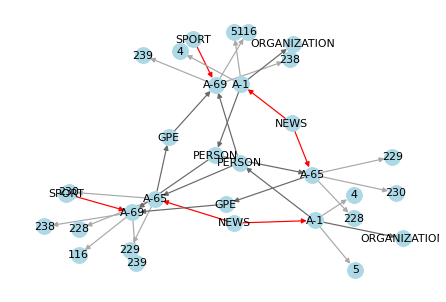

,main_edge_colour,main_edge_width,sentiment_score_ranges
0,black,0.4,-1 to -0.6
1,darkviolet,0.8,-0.6 to -0.2
2,red,1.2,-0.2 to 0.2
3,dodgerblue,1.6,0.2 to 0.6
4,lawngreen,2.0,0.6 to 1.0


,article_number,title,link
0,7,Climate change: Is the UK on track to meet its targets?,https://www.bbc.com/news/58160547
1,8,Drought emergency declared in northern Italy,https://www.bbc.com/news/world-europe-62046165
2,30,"Australia floods: 50,000 on evacuation alert after deluge hits Sydney",https://www.bbc.com/news/world-australia-61991112
3,36,"Floating wind farms at sea to create 29,000 jobs - Crown Estate",https://www.bbc.com/news/uk-wales-62037754
4,37,Last Supper targeted by climate protesters at Royal Academy,https://www.bbc.com/news/uk-england-london-62050348
5,40,Climate protesters glue themselves to John Constable masterpiece,https://www.bbc.com/news/uk-england-london-62038615
6,56,Climate change: Northern Ireland pupils to study new qualification,https://www.bbc.com/news/uk-northern-ireland-62008312
7,63,Prince Charles airs climate frustration on BBC Wales visit,https://www.bbc.com/news/uk-wales-62034657
8,74,Climate change: 'Sand battery' could solve green energy's big problem,https://www.bbc.com/news/science-environment-61996520


,entity_number,entity,search_term,ner_wikipedia_summary
0,4,"(Climate, PERSON)",Climate,"Climate is the long-term weather pattern in an area, typically averaged over 30 years."
1,133,"(Crown Estate, PERSON)",Crown Estate,"The Crown Estate is a collection of lands and holdings in the United Kingdom belonging to the British monarch as a corporation sole, making it ""the sovereign's public estate"", which is neither government property nor part of the monarch's private estate.The sovereign is not involved with the management or administration of the estate, and exercises only very limited control of its affairs."
2,134,"(Wales, GPE)",New South Wales,New South Wales (commonly abbreviated as NSW) is a state on the east coast of Australia.
3,135,"(Crown Estate, ORGANIZATION)",Crown Estate,"The Crown Estate is a collection of lands and holdings in the United Kingdom belonging to the British monarch as a corporation sole, making it ""the sovereign's public estate"", which is neither government property nor part of the monarch's private estate.The sovereign is not involved with the management or administration of the estate, and exercises only very limited control of its affairs."
4,136,"(Wales, PERSON)",New South Wales,New South Wales (commonly abbreviated as NSW) is a state on the east coast of Australia.
5,137,"(Royal Gallery, ORGANIZATION)",Royal Gallery of Illustration,The Royal Gallery of Illustration was a 19th-century performance venue located at 14 Regent Street in London.
6,138,"(Renaissance, GPE)",Renaissance,"The Renaissance (UK: rin-AY-sənss, US: (listen) REN-ə-sahnss) is a period in European history marking the transition from the Middle Ages to modernity and covering the 15th and 16th centuries, characterized by an effort to revive and surpass ideas and achievements of classical antiquity."
7,139,"(Royal Academy, ORGANIZATION)",Royal Academy of Arts,The Royal Academy of Arts (RA) is an art institution based in Burlington House on Piccadilly in London.
8,13,"(UK, ORGANIZATION)",United Kingdom,"The United Kingdom of Great Britain and Northern Ireland, commonly known as the United Kingdom (UK) or Britain, is a sovereign country in Europe, off the north-western coast of the continental mainland."
9,141,"(JSO, ORGANIZATION)",Special Operations Unit (Serbia),"Unit for Special Operations (Serbian: Јединица за специјалне операције, romanized: Jedinica za specijalne operacije; abbr."


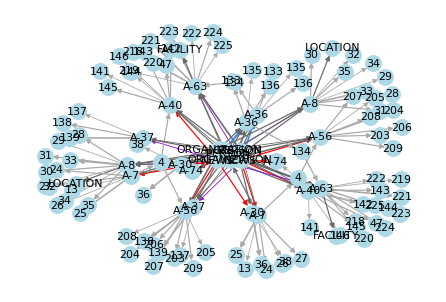

,main_edge_colour,main_edge_width,sentiment_score_ranges
0,black,0.4,-1 to -0.6
1,darkviolet,0.8,-0.6 to -0.2
2,red,1.2,-0.2 to 0.2
3,dodgerblue,1.6,0.2 to 0.6
4,lawngreen,2.0,0.6 to 1.0


,article_number,title,link
0,1,Climate change: Financial incentives essential for net zero switch,https://www.bbc.com/news/uk-northern-ireland-61986849
1,65,Olympic medallist schools Devon pupils on climate,https://www.bbc.com/news/uk-england-devon-61997107
2,69,"'Way too much tennis' in 'unsustainable' calendar, says Laura Robson",https://www.bbc.com/sport/tennis/61999471


,entity_number,entity,search_term,ner_wikipedia_summary
0,228,"(Plympton Academy, PERSON)",Plympton Academy,"Plympton Academy (formerly, The Ridgeway School and, before that, Plympton County Secondary School) is a state secondary school in Plympton, Plymouth, England."
1,229,"(Hannah Mills, PERSON)",Hannah Mills,"Hannah Mills, (born 29 February 1988) is a British competitive sailor and two-time world champion in the Women's 470 class, having won in 2012 and 2019."
2,4,"(Climate, PERSON)",Climate,"Climate is the long-term weather pattern in an area, typically averaged over 30 years."
3,5,"(NI Utility, ORGANIZATION)",NiSource,NiSource Inc.
4,230,"(Plymouth, GPE)",Plymouth,Plymouth ( (listen)) is a port city and unitary authority in South West England.
5,238,"(Laura Robson, PERSON)",Laura Robson career statistics,This is a list of the main career statistics of professional British tennis player Laura Robson.
6,239,"(Robson, PERSON)",Wade Robson,Wade Jeremy William Robson (born 17 September 1982) is an Australian dancer and choreographer.
7,116,"(British, GPE)",British Empire,"The British Empire was composed of the dominions, colonies, protectorates, mandates, and other territories ruled or administered by the United Kingdom and its predecessor states."


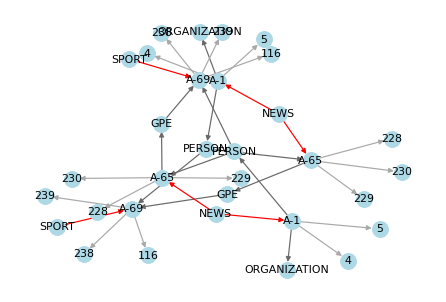

In [45]:
output = widgets.Output()

# creating a dropdown menu for categories
options = ['all']
options.extend(list(df_final['category1'].unique()))
dropdown = widgets.Dropdown(options=options, description="Categories")

# creating a date picker
dp = widgets.DatePicker(value = datetime.date(2022,5,1), description='Date')

# plot function
def plot_sentiment(date_selected, category_selected='news'):
    output.clear_output()
    
    # data
    df_temp = df_final[df_final['date'] == pd.to_datetime(date_selected, format = '%Y-%m-%d %H:%M:%S')]
    try:
        if val_cat != 'all':
            df_temp = df_temp[df_temp['category1'] == val_cat]
    except NameError:
        pass
    
    knowledge_graph(df_temp)
    
    x = df_temp['index']
    y = df_temp['sentiment_score']
    
    # layout
    layout = go.Layout(
        title='Sentiment Scores from Vader',
        xaxis=dict(
            title='Article Index'),
        yaxis=dict(
            title='Scores')
    )
    
    # figure
    figure = go.Figure(layout=layout)
    
    # adding a scatter trace to the figure
    figure.add_trace(
        go.Scatter(
            mode='markers',
            x=x,
            y=y,
            marker=dict(
                color='darkturquoise',
                size=12,
                opacity=0.5,
                line=dict(
                    color='burlywood',
                    width=1)
                        ),
            showlegend=False
        )
    )
    
    # displaying the output (the figure)
    with output:
        display(figure.show())
        display(Image(filename='filename.png'))
        display(knowledge_graph(df_temp))
        
def select_category(category_selected):
    output.clear_output()
    
    # data
    if category_selected != 'all':
        df_temp = df_final[df_final['category1'] == category_selected]
    else:
        df_temp = df_final.copy()
    try:
        df_temp = df_temp[df_temp['date'] == pd.to_datetime(val_date, format = '%Y-%m-%d %H:%M:%S')]
    except NameError:
        df_temp = df_temp[df_temp['date'] == datetime.date(2022,1,1)]
    
    knowledge_graph(df_temp)
    
    x = df_temp['index']
    y = df_temp['sentiment_score']
    
    # layout
    layout = go.Layout(
        title='Sentiment Scores from Vader',
        xaxis=dict(
            title='Article Index'),
        yaxis=dict(
            title='Scores')
    )
    
    # figure
    figure = go.Figure(layout=layout)
    
    # adding a scatter trace to the figure
    figure.add_trace(
        go.Scatter(
            mode='markers',
            x=x,
            y=y,
            marker=dict(
                color='turquoise',
                size=12,
                opacity=0.5,
                line=dict(
                    color='burlywood',
                    width=1)
                        ),
            showlegend=False
        )
    )
    
    # displaying the output (the figure)
    with output:
        display(figure.show())
        display(Image(filename='filename.png'))
        display(knowledge_graph(df_temp))

def colors_weights(score, score_thresholds_l = score_thresholds, colors_l = colors_list, weights_l = weights_list):
    """
    Assigns a colour/weight to a main edge (meaning an edge that connects a category node to an article index node)
    """
    for i in range(len(score_thresholds)):
        if score < score_thresholds[i]:
            return [colors_list[i], weights_list[i]]

def knowledge_graph(df):

    G = nx.Graph()

    edges = []

    entities = []

    sent_scores = []
    
    titles_links = []

    for i in range(len(df)):
        edges.append((df['category1'].iloc[i].upper(), df['index'].iloc[i]))
        sent_scores.append(df['sentiment_score'].iloc[i])
        entities.append((df['entities'].iloc[i]))
        
        d_temp = {}
        d_temp.update({'article_number': df['index'].iloc[i], 'title': df['title'].iloc[i], 'link': df['link'].iloc[i]})
        titles_links.append(d_temp)

    titles_links_df = pd.DataFrame.from_dict(titles_links)
    # making the links in the DataFrame clickable
    titles_links_df = HTML(titles_links_df.to_html(render_links=True, escape=False))
    
    entities_temp = []
    for i in range(len(edges)):
        # edges[i][0] : category, edges[i][1] : article index (A for article)
        G.add_edge(edges[i][0], f"A-{edges[i][1]}",
                   color = colors_weights(round(sent_scores[i], 3))[0],
                    weight = colors_weights(round(sent_scores[i], 3))[1])
        for j in range(len(entities[i])):
            entities_temp.append(d_ents[entities[i][j]])
            # edges[i][1] : article index, d_ents[entities[i][j]] : index of pair of token/term and named entity
            G.add_edge(f"A-{edges[i][1]}", d_ents[entities[i][j]], color='darkgrey')
            # edges[i][1] : article index, final_edges(entities[i])[j][0] : name of entity
            G.add_edge(f"A-{edges[i][1]}", final_edges(entities[i])[j][0], color='dimgrey')
            
    colors = list(nx.get_edge_attributes(G,'color').values())
    weights = list(nx.get_edge_attributes(G,'weight').values())
    
    display(cols_weights_thresholds(colors_list, weights_list, score_thresholds))
    
    display(titles_links_df)
    
    display(find_entities(entities_df, list(set(entities_temp)), ner_summaries_df))

    nx.draw(G, with_labels=True, node_size=250, node_color='lightblue', edge_color=colors, width=weights, font_size=11,
           arrows=True)
    plt.savefig("filename.png")
        
# creating an event handler (the value/date comes from the display variable)
def event_handler_date(value):
    global val_date
    val_date = value.new
    plot_sentiment(value.new) # with .new we are getting the most recent value coming from DatePicker
     
def dropdown_event_handler(value):
    global val_cat
    val_cat = value.new
    select_category(value.new) # with .new we are getting the most recent value coming from the dropdown menu
    
# binding the event handler to the DatePicker user input (via display(dp)) by observing the event (the user's click - when that
# happens the value the user provides is passed into the event_handler_date function, which then passes that into the 
# plot_sentiment function and the plot is generated)
dp.observe(event_handler_date, names='value')

# binding the event handler to the categories dropdown menu user input (via display(dropdown)) by observing the event
dropdown.observe(dropdown_event_handler, names='value')

# displaying the DatePicker
display(dp)

# displaying the dropdown menu
display(dropdown)

In [46]:
# displaying the output coming from figure.show()
display(output)

Output()